This notebook contains all the pieces necessary to train and run a predictor - in this case a random forest classifier

I've tried to split it into logical pieces

### Prep environment ###

Because I built this ahead of time, I know what all my imports are. If I was building this from scratch, I would do broad imports (`import pandas as pd`, for instance)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas import DataFrame, Series, read_csv, set_option
from numpy import array, sqrt
from random import seed, shuffle

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier


# Want reproducible results
seed(0)

# Force the console output to be wider - impacts the width of print statements
set_option('display.width', 180)

### Explore raw data ###

Before we can know which features we want to clean, scale, etc, we need to take a look at what the raw data contains. Pandas DataFrame objects are great for this - they preserve the structure of the data and provide a lot of quick and easy tools for exploration

In [3]:
# Read in the data
data = read_csv('hr_data.csv')
# NOTE: jupyter notebooks have a built-in Pandas DataFrame viewer, so rather than `print df.head()`,
#       just use df.head() and the output will be formatted for you. Unfortunately, it will only
#       track the last command you enter, so trying to write out data.head() and data.info() in the same
#       cell will only show the data.info() output
data.head()
# data.info()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


A couple of quick items to note:
* No missing (null) values, as shown in data.info()
* Some misspelled (or just poorly named) fields - `average_montly_hours`, `Work_accident`, etc
* A couple of text fields: `sales`, `salary`  Will need to be mapped or excluded

Off the bat we see we will want to clean some field names and map whatever text fields that we can before including them in the model. We also note that 15k observations, while providing a good opportunity to learn and to extract potentially valuable insights *for the company whose data it is*, this is not enough observations to build a model that will generalize well.

#### Visualize ####

Next we want to take a closer look at each feature. I have a couple of questions I often ask right away:

* What kind of feature is this? i.e. Categorical or continuous?
* What kind of distribution would fit this feature? i.e. Normal, uniform, etc
* Are there any potential outliers? 
* Will I need to perform any transformations on this feature? Rescale, standardize, log-normalize, etc

We're not interested in viewing all 15k values per feature. What we want to look at is the distribution (density) of the values. One common way to do this is to split the data into N (say, 10) bins, then count the number of points in each bin, and then plot a bar chart where the height of each bar is the number of points in that bin. See https://en.wikipedia.org/wiki/Histogram for details.

satisfaction_level       Axes(0.125,0.125;0.775x0.755)
last_evaluation          Axes(0.125,0.125;0.775x0.755)
number_project           Axes(0.125,0.125;0.775x0.755)
average_montly_hours     Axes(0.125,0.125;0.775x0.755)
time_spend_company       Axes(0.125,0.125;0.775x0.755)
Work_accident            Axes(0.125,0.125;0.775x0.755)
left                     Axes(0.125,0.125;0.775x0.755)
promotion_last_5years    Axes(0.125,0.125;0.775x0.755)
dtype: object

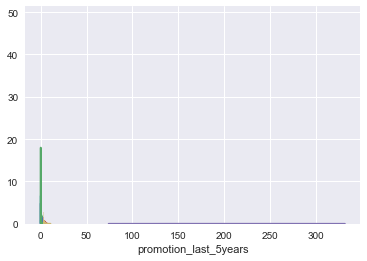

In [6]:
# While I could try to save time by plotting everything at once, that's often not a good idea
# Even if the variables were rescaled, it becomes very difficult to tell them apart when they are
# all plotted on top of each other
# Also, because `sales` and `salary` are text fields, I can't plot them
data.drop(['sales', 'salary'], axis=1).apply(lambda x: sns.distplot(x))

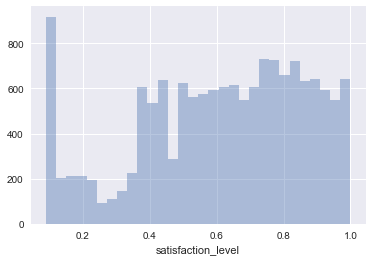

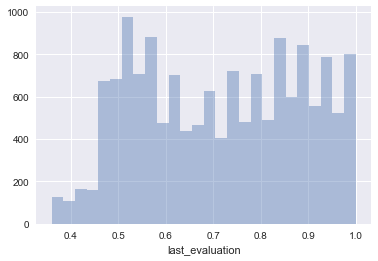

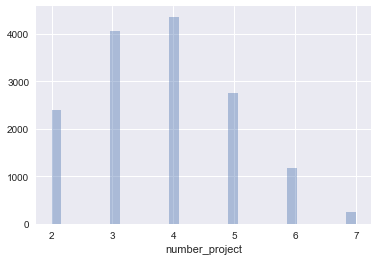

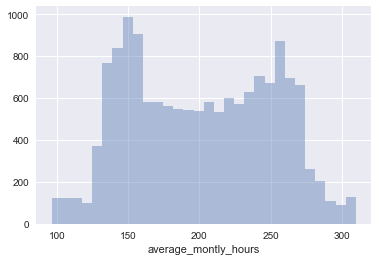

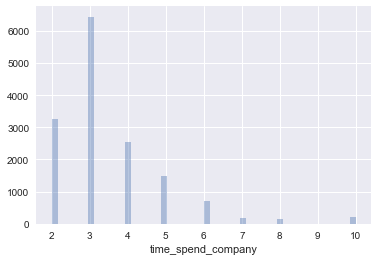

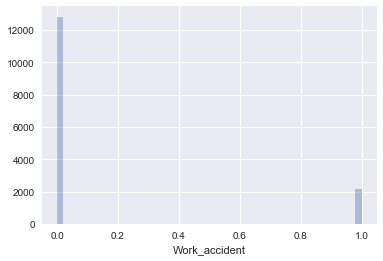

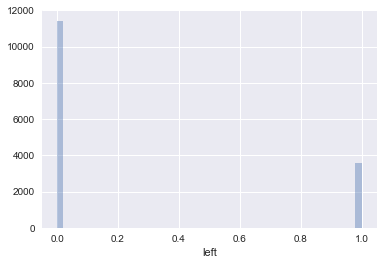

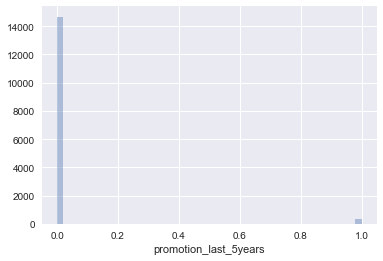

In [7]:
# Instead, we plot each independently and scrutinize these plots
for series_header, series_values in data.drop(['sales', 'salary'], axis=1).iteritems():
    plt.figure()
    sns.distplot(s, label=i, hist=True, kde=False)
    # plt.legend()

**General Notes**

`satisfaction_level` has a buildup around 0. It seems uncharacteristic, given the shape of the feature, and I wonder if may be some sort of artifact of the survey. `average_monthly_hours` looks like it is a smoothing of two groups (e.g. bimodal). We may want to dig into that later and see if we can break out those groups. I also find it a bit strange that both `number_project` and `time_spend_company` have minimums at 2. `time_spend_company` is likely due to survey design, but I wonder if `number_project` speaks to how the company operates (everybody must have at least 2 projects at any time?).

**Feature notes**

Categorical:
  * promotion_last_5years (binary)
  * left (binary)
  * Work_accident (binary)

Continuous:
  * time_spend_company (# years | [2, 10] | beta?)
  * average_montly_hours (# hours/month | [~100, ~300] | bimodal)
  * number_project (# | [2, 7] | ~normal or beta?)
  * last_evaluation (rating of employee | [0,1] | ~uniform?)
  * satisfaction_level ([0,1] | ~uniform?)
  
We excluded `sales` and `salary` from the plots, so let's try to dig into them a different way...

In [8]:
# 'sales' is the header for departments
x = data['sales']
# x.groupby(x).count()  # I suggest using the built-in functions as much as possible
print x.value_counts()
print data['salary'].value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64
low       7316
medium    6446
high      1237
Name: salary, dtype: int64


It's clear that `sales` is actually a listing of departments within the company. I find it interesting that the salary was masked into three broad bins. Maybe that has to do with privacy issues?

`sales` is a typical categorical variable: "IT" is different from "hr", but "IT" is not any larger (or smaller) than "hr". This means that we can't map to a numerical representation. Instead, if we wanted to include `sales`, we would have to construct a series of dummy variables that assign each observation to the proper `sales` value. That's easy enough with Pandas (`get_dummies`), but I'm going to skip that for now and just drop the feature.

`salary`, on the other hand, is an ordered set of values: low < medium < high. We can capture this relationship by mapping to an ordinal range (e.g. range(0, len(`salary`)) and assigning values properly. 

### Pre-processing ###

Now that we have a good feel for what is in this data set, we can make a few decisions and clean up the data some.

In particular, I know that I will want to standardize the continuous variables (in particular, I really want to rescale `average_montly_hours`). As a practice, I like to standardize all of my continuous variables before using them to build a model, but I don't think it would be strictly necessary for most of these features. I also note that I will need to map `salary` values, and that I will drop off `sales`

I don't see any obvious outliers in any of the features.

In [9]:
# Known transformations we want to apply to the data
def hr_pre_process(dat, drop_cols=['salary', 'dept']):
    # Quick name cleaning
    dat = dat.rename(columns={'promotion_last_5years': 'promotion', 
                                'Work_accident': 'work_accident',
                                'average_montly_hours': 'average_monthly_hours',
                                'number_project': 'number_projects', 
                                'sales': 'dept'})
    
    salary_dict = {'low': 0, 'medium': 1, 'high': 2}

    dat['salary_map'] = dat['salary'].map(salary_dict)

    for col in drop_cols:
        dat.drop(col, axis=1, inplace=True)

    return dat

** NOTE ** This isn't the right place to perform feature scaling, but as I am defining the functions in this file, and that needs to be done ahead of time, I will include a quick discussion here. None of this will actually be applied to the data until further on.

### Feature Scaling ###

See [feature_scaling](https://en.wikipedia.org/wiki/Feature_scaling)

If we want to use a machine learning algorithm that depends on the magnitude of the inputs, for instance calculating distances of points to cluster means as in [k-means](https://en.wikipedia.org/wiki/K-means_clustering), we will need to standardize those features before training the algorithm or we risk allowing features with larger ranges to dictate the learning of the model. Most clustering algorithms (as a subset of classifiers) are good examples of this.

On the other hand, most regression models fit higher-order moments of the data, and are therefore less susceptible to this. However, in many cases, to solve linear equations, the pseudo-inverse of the input matrix is needed, and it can become very difficult to calculate this if the range of the features is not normalized. I argue that it's better safe than sorry, and I standardize (or, at least, rescale) by default. 

Of course, running a standardization on any feature has a serious implications: the feature now exists in a different, parameterized space, as defined by whatever parameters are used to scale (e.g. mean and variance). This means that these parameters must be tracked carefully if we want to recover the original values and/or if we want to properly project the validation data into the parameterized space (which, presumably, we do)

#### Standardization ####

See [standard_score](https://en.wikipedia.org/wiki/Standard_score)

Standardization is the process of converting all values to their z-scores, which is the distance, in units of standard deviation, of each point to the population mean. It allows for direct comparison of the distributions of variables.

In [10]:
# --------------- Feature Scaling -----------
# For expository purposes, I am leaving everything explicitly defined in this file.
# These functions should moved into a general purpose utility file, then imported for use here

# The s that will be passed through is list type, array, or series

def calc_mean(s):
    return sum(s)/float(len(s))

# variance (spread of points in population) = sum of ((x - mean of x)^2) / count of x
def calc_var(s):
    mean_s = calc_mean(s)
    return sum((s-mean_s)**2)/float(len(s))

def rescale(s):
    return (s-min(s))/float(max(s) - min(s))

# will standardize two different data sets - first, training data and later, validation data. 
# only way is to use the trained parameters you calculated prior.
def standardize(s, mean_s=None, var_s=None):
    if mean_s is None:
        mean_s = calc_mean(s)

    if var_s is None:
        var_s = calc_var(s)
        
    # (s-mean_s) centers the mean on zero. It has an arbitrary spread. 
    # you want to make the spread the unit of standard deviation. AKA take sq root of variance.
    s_ = (s-mean_s)/sqrt(var_s)
    return s_, mean_s, var_s

# need to figure out a better name for this
def build_standardize(df, categoricals, params=None):
    # Don't normalize categorical variables
    # Pull them out, hold them aside before processing
    df_hold = df[categoricals]
    df = df.drop(categoricals, axis=1)

    if params is None:
        params = {}
        df_norm = DataFrame(columns=df.columns)
        # Iterate across columns
        for lab, col in df.iteritems():
            col_, col_mean, col_var = standardize(col)
            params[lab] = {'mean': col_mean, 'var': col_var}
            df_norm[lab] = col_

    else:
        df_norm = DataFrame(columns=df.columns)
        # Iterate across columns
        for lab, col in df.iteritems():
            col_, col_mean, col_var = standardize(col, params[lab]['mean'], params[lab]['var'])
            df_norm[lab] = col_

    df_norm = df_norm.join(df_hold)
    return df_norm, params

In [11]:
# What did standardization do?
dat, _ = build_standardize(hr_pre_process(data), ['salary_map', 'promotion', 'left', 'work_accident'])
# non-standardized (std = standard deviation)
print 'non-standardized average_monthly_hours s.d.: {}'.format(dat['average_monthly_hours'].std())
# standardized
print 'standardized average_monthly_hours s.d.: {}'.format(dat['average_monthly_hours'].std())

non-standardized average_monthly_hours s.d.: 1.00003333722
standardized average_monthly_hours s.d.: 1.00003333722


### Modeling ###

See [mathematical_model](https://en.wikipedia.org/wiki/Mathematical_model)

Modeling a phenomenon involves finding the relationship between an input variable (or a series of variables), and a target output variable. A full discussion of different types of models is beyond the scope of this notebook, but [this](https://en.wikipedia.org/wiki/Machine_learning#Types_of_problems_and_tasks) is a good place to start.

To decide on a model, I ask myself a series of questions:

* What am I going to predict? What is the distribution of my output variable: continuous, categorical, or binary?

The answer dictates whether we want to consider regressors (continuous) or classifiers (categorical, binary). In this case, we want to predict `left`, which is binary.

* What are the distributions of my input variables?

I find that linear/non-linear regressors work best with continuous input variables, where they can fit the covariance of the output with the inputs - the categorical/binary variables amount to a series of constant offsets and aren't paricularly useful. Decision trees, on the other hand, are much better at handling categoricals.

We have a mix of continuous and categorical input features.

* What model should I use for this problem?

A random forest classifier should work well here. 

#### Hyperparameters ####

If we were going to put a model into production, we would want to work to optimize it. Most models have hyperparameters that can be tuned to try and improve performance. For a random forest classifier, we might want to increase the number of trees in the forest (`n_estimators`) or switch the `criterion` from gini to entropy. For all parameters of the scikit learn random forest, see the [docs](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

Looking at the plot of `left` above, I see that there is a roughly 4:1 ratio of False:True (e.g. 4/5 of people stayed). we will want to use this information to start the forest off on a better foot, so we'll make use of the `class_weight` hyperparameter.

#### Cross Validation ####

See [cross_validation]( https://en.wikipedia.org/wiki/Cross-validation_(statistics) )

In order to judge the likely efficacy of my model, we will split our data into multiple pieces, then iterate across them and train/test on different splits of the data. This general process is called k-fold cross validation, where k is the number of pieces we split our data into. Common values of k are 5 and 10. I use a minimum of k=5, and depending on how much data I have, and whether or not I intend to put this model into production, I go up to 10 or even 15 folds. 

The average accuracy across all folds is then the expected accuracy of the model, and is the number I use to judge this model against other models (or sets of hyperparameters). It's important to note that this k-fold average accuracy measure is not my final accuracy measure for the model.

As mentioned in **hyperparameters**, the target variable `left` is biased towards 0 (roughly 4:1). When running our k-folds, I have to be careful to preserve that relationship in the observations within each split. If we don't, we risk providing the model an incorrect split of the output, which it will then learn. This is called a **stratified** split. Luckily, scikit learn provides a way to do this easily ([stratified k fold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)). So, rather than build something from scratch, we will leverage this function.

#### Validation Set ####

If we want a measure of how well my model can be expected to perform on data *it has never seen* (and I do), we will split off a large piece of my data and hold that aside until the very end. This piece of data will be my **validation set**, and the performance of my model on this validation set is the true measure of how well we can expect my model to perform on novel data (i.e. how well it will generalize).

#### Accuracy ####

Calculating accuracy of a binary classifier is very straightforward: 

accuracy = sum(# correct classifications)/(# classifications)

In [12]:
cat_cols = ['salary_map', 'promotion', 'left', 'work_accident'] # define for later use

# shuffle to remove any bias in the order of the samples
idx = array(data.index)
shuffle(idx)
dat = data.ix[idx].reset_index(drop=True)

# f is fraction of samples to use as validation
f = 0.25
N = len(dat)
# validation set
dat_val = dat.iloc[:int(f*N), :].reset_index(drop=True)  # first 25% (f%)
# training set
dat = hr_pre_process(dat.iloc[int(f*N):, :].reset_index(drop=True))  # remaining data

# Let sklearn find stratified splits for us
# Shuffle is unnecessary here, since we shuffled above
SKF = StratifiedKFold(n_splits=5, shuffle=False, random_state=0)
k_splits = SKF.split(dat.drop('left', axis=1), dat['left'])

# Per split, train model and use run_model to collect probabilities, predictions, and actual values
# Push into dataframe on each loop for analysis after all folds
accuracy = []
for train_idx, test_idx in k_splits:

    train = dat.iloc[train_idx, :]  # pull out training data
    test = dat.iloc[test_idx, :]  # pull out testing data

    # Apply feature scaling
    train_, params = build_standardize(train, cat_cols)
    test_, _ = build_standardize(test, cat_cols, params)

    init_weights = train['left'].value_counts().to_dict()
    
    # training model step
    tmp_model = RandomForestClassifier(class_weight=init_weights, random_state=0).fit(train_.drop('left', axis=1), train_['left'])

    # run model (make predictions)
    y = test_['left']
    y_pred = tmp_model.predict(test_.drop('left', axis=1))

    # Calculate accuracy = (# correct classifications)/(# inputs)
    acc = sum(y==y_pred)/float(len(y))

    accuracy.append(acc)

acc_mean = sum(accuracy)/float(len(accuracy))
print 'Average training accuracy: {}%'.format(round(acc_mean, 3)*100.)

Average training accuracy: 98.8%


At this point, we have a decision to make: are we happy with the accuracy we're seeing, or should we go back and make some changes? Any hyperparameter tweaks or model comparisons should happen here. Only when we have chosen a model to move forward with, and we are happy with the results, should we move on to the next step. 

#### Judging Performance ####

One obvious question to ask is: should we be happy with these results? 

98.8% seems pretty good, but what if it was only, say, 75%. Would that be good? We've developed this model in a vacuum (so far), so our reference points are limited. Because this data is sourced from Kaggle, it will be easy to compare our results with others to get a feel for what contitutes "good" performance here (see [kaggle_hr_analytics](https://www.kaggle.com/ludobenistant/hr-analytics))

If we didn't have any external reference points, what could we do? I like to take two simple reference measurements

* performance of a "null" predictor
* average across multiple different types of models

For now, we will disregard comparison across different types of models, and instead focus on the null predictor. What I mean by null predictor is a predictor that performs equal to random chance. In the case of a classifier with N *balanced* classes, the expected chance of guessing any given observation correct is `1/N`.

I'm particularly interested in the null predictor as my baseline for performance - we don't need any outside information to determine the null predictor rate, and it serves as my threshold for any claim that the model actually **learned** something from the data. If I provided you a model that predicted correct binary classification at 50%, that would suggest that the model didn't learn anything, and it was therefore not useful.

In this case of this data, our null predictor needs to be adjusted. We have two classes (`left`= True or False), but those classes are not represented evenly in our data. Instead, `left`=False dominates. Because of this, I adjust my null predictor to be biased and always predict whatever the dominant class is - in this case, `left`=False. If we do this, our performance would be:

In [13]:
null_pred = sum(dat['left']==False)/float(len(dat['left']))

print 'Expected performance of null predictor: {}%'.format(round(null_pred, 3)*100.)
print 'Percent improvement of model over null: {}%'.format(round(((acc_mean-null_pred)/null_pred), 3)*100.)

Expected performance of null predictor: 76.2%
Percent improvement of model over null: 29.6%


So, had the model learned nothing, and just predicted that all employees would stay, we would see performance of 76.2%. Our model's expected accuracy is 98.8%; that's an improvement of 30% over the null. Based on this significant improvement over what is effectively chance for this data, I would be confident in reporting that this model has learned something meaningful from the data. 

In [14]:
# ------------ up to this point, I can tweak/change model and/or model parameters ----------------
# ---------- !! no decisions can be based on the results of the validation set !! ----------------

# re-parameterize with entire training set
dat_, params = build_standardize(dat, cat_cols)
dat_val_, _ = build_standardize(hr_pre_process(dat_val), cat_cols, params)

init_weights = dat_['left'].value_counts().to_dict()

# Implement model
model = RandomForestClassifier(class_weight=init_weights, random_state=0).fit(dat_.drop('left', axis=1), dat_['left'])

# run predictions on validation step
y = dat_val_['left']
y_pred = model.predict(dat_val_.drop('left', axis=1))

gen_acc = sum(y==y_pred)/float(len(y))
gen_err = 1. - gen_acc

print 'Expected generalization accuracy: {a}%  (error: {e}%)'.format(
    a=round(gen_acc, 3)*100., e=round(gen_err, 3)*100.)

Expected generalization accuracy: 98.9%  (error: 1.1%)


#### Insights ####

We started off by asking if we could determine which employees would leave, given their measurements on certain metrics. While that's useful in and of itself, we can also dig into the model to ask more particular questions, such as

* Which features were most important?
* What would it take to get those employees to stay?

Let's start with the highest-level takeaways and drill down from there. 

In [15]:
# Join predictions back in
d = hr_pre_process(dat_val, drop_cols=['salary'])
d['pred'] = y_pred

print 'Expected number of employees leaving: {}'.format(d['pred'].sum())
print 'Expected fraction of employees leaving: {}'.format(d['pred'].sum()/float(len(d['pred'])))

Expected number of employees leaving: 878
Expected fraction of employees leaving: 0.234195785543


~23% of people leaving is roughly the rate we saw in the training data, so that is not a surprising outcome. As we have no basis for judging this number (i.e. is this number high, low, or expected?), we will refrain from doing so. We can look at which departments these people are coming from

In [20]:
d.groupby('dept')['pred'].sum().sort_values(ascending=False)

dept
sales          261
technical      166
support        148
IT              78
hr              55
product_mng     48
accounting      46
marketing       41
RandD           20
management      15
Name: pred, dtype: int64

Interesting (or maybe not) that Sales is expect to see the most employees leave. 

At this point, we can try to dig into the model to see what it learned and what that can tell us. Because we used a random forest, this is a difficult exercise; random forests can rank features according to how much each feature impacted the result, but that won't tell you much about the causal links between the variables. Contrast that with, say, a linear regressor, which has weights almost directly related to the cross correlation between variables. Meaning, with a linear regressor, I can estimate how much impact on the output each input feature has, and I can try to use this to affect a different result.

In [16]:
# feats = [(f, i) for i, f in zip(model.feature_importances_, dat_.drop('left', axis=1).columns)]
feats = Series(data=model.feature_importances_, index=dat_.drop('left', axis=1).columns, name='importance')

print 'Ordered list of features, according to random forest:\n{}'.format(feats.sort_values(ascending=False))

Ordered list of features, according to random forest:
satisfaction_level       0.385724
average_monthly_hours    0.193279
number_projects          0.158381
time_spend_company       0.132176
last_evaluation          0.106513
salary_map               0.015875
work_accident            0.007311
promotion                0.000740
Name: importance, dtype: float64


According to our model, `satisfaction_level` is the most important feature when determining when an employee will leave, whereas (perhaps surprisingly) whether or not the employee recieved a `promotion` is least important.